In [1]:
import os
import numpy as np
import tensorflow as tf
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.applications import MobileNetV2
from tensorflow.keras.layers import Dense, Flatten, Dropout, GlobalAveragePooling2D, Input
from tensorflow.keras.models import Model
from sklearn.metrics import classification_report, accuracy_score
from tensorflow.keras.regularizers import l2

In [3]:
import warnings
warnings.filterwarnings("ignore")  # Suppress warnings

In [23]:
#step 2 data preprocessing

from sklearn.model_selection import train_test_split
import numpy as np

def load_data(dataset_dir, img_size=(224, 224), batch_size=16, test_split=0.5):
    train_datagen = ImageDataGenerator(
        rescale=1./255,
        rotation_range=30, width_shift_range=0.2, height_shift_range=0.2,
        shear_range=0.2, zoom_range=0.3, brightness_range=[0.8, 1.2],
        horizontal_flip=True, fill_mode='nearest', validation_split=0.2
    )

    val_test_datagen = ImageDataGenerator(rescale=1./255)  

    class_order = ['normal', 'cataract', 'diabetic_retinopathy', 'glaucoma']  # Ensure all classes exist

    # Load training data (80%)
    train_data = train_datagen.flow_from_directory(
        dataset_dir, target_size=img_size, batch_size=batch_size,
        class_mode='categorical', subset='training', classes=class_order)

    # Load validation + test data (20%)
    val_test_data = train_datagen.flow_from_directory(
        dataset_dir, target_size=img_size, batch_size=batch_size,
        class_mode='categorical', subset='validation', shuffle=False, classes=class_order)

    # Extract all images and labels from validation+test dataset
    val_test_images = []
    val_test_labels = []

    for _ in range(len(val_test_data)):  # Go through all batches
        batch_images, batch_labels = next(val_test_data)  # ✅ Correct: Use next(iterator)
        val_test_images.append(batch_images)
        val_test_labels.append(batch_labels)

    val_test_images = np.concatenate(val_test_images, axis=0)
    val_test_labels = np.concatenate(val_test_labels, axis=0)

    # Convert one-hot labels to categorical class indices
    val_test_labels_indices = np.argmax(val_test_labels, axis=1)

    # Split into validation & test (stratified by class index)
    val_images, test_images, val_labels_indices, test_labels_indices = train_test_split(
        val_test_images, val_test_labels_indices, test_size=test_split, stratify=val_test_labels_indices, random_state=42
    )

    # Convert labels back to one-hot encoding
    num_classes = len(class_order)
    val_labels = np.eye(num_classes)[val_labels_indices]
    test_labels = np.eye(num_classes)[test_labels_indices]

    return train_data, (val_images, val_labels), (test_images, test_labels)

# Load data
retinal_train, (retinal_val_images, retinal_val_labels), (retinal_test_images, retinal_test_labels) = load_data("/Users/blessygrace/Desktop/Capstone 2/seg_dataset")

def load_brain_data(train_dir, test_dir, img_size=(224, 224), batch_size=16):
    
    train_datagen = ImageDataGenerator(
    rescale=1./255,
    rotation_range=30,
    width_shift_range=0.2,
    height_shift_range=0.2,
    shear_range=0.2,
    zoom_range=0.3,
    brightness_range=[0.8, 1.2],
    horizontal_flip=True,
    fill_mode='nearest',
    validation_split=0.2  # Keep validation split
)
    test_datagen = ImageDataGenerator(rescale=1./255)
    
    class_order = ['notumor', 'glioma', 'meningioma', 'pituitary']  # Explicit class order
    
    train_data = train_datagen.flow_from_directory(train_dir, target_size=img_size, batch_size=batch_size,
                                             class_mode='categorical', classes=class_order)
    test_data = test_datagen.flow_from_directory(test_dir, target_size=img_size, batch_size=batch_size,
                                            class_mode='categorical', shuffle=False, classes=class_order)
    return train_data, test_data

brain_train, brain_test = load_brain_data("/Users/blessygrace/Desktop/Capstone 2/brainmri/Training", "/Users/blessygrace/Desktop/Capstone 2/brainmri/Testing")


Found 3376 images belonging to 4 classes.
Found 841 images belonging to 4 classes.
Found 5712 images belonging to 4 classes.
Found 1311 images belonging to 4 classes.


In [7]:
from collections import Counter

# Training set distribution
train_counts = Counter(retinal_train.classes)

# Validation & Test set distribution
val_counts = Counter(np.argmax(retinal_val_labels, axis=1))
test_counts = Counter(np.argmax(retinal_test_labels, axis=1))

print("Training set class distribution:", train_counts)
print("Validation set class distribution:", val_counts)
print("Test set class distribution:", test_counts)


# Check distribution in training, validation, and test labels
train_counts = Counter(brain_train.classes)
test_counts = Counter(brain_test.classes)

print("Training set class distribution:", train_counts)
print("Test set class distribution:", test_counts)

Training set class distribution: Counter({2: 879, 0: 860, 1: 831, 3: 806})
Validation set class distribution: Counter({2: 109, 0: 107, 1: 103, 3: 101})
Test set class distribution: Counter({2: 110, 0: 107, 1: 104, 3: 100})
Training set class distribution: Counter({0: 1595, 3: 1457, 2: 1339, 1: 1321})
Test set class distribution: Counter({0: 405, 2: 306, 1: 300, 3: 300})


In [9]:
print("Class Indices:", retinal_train.class_indices)
print("Class Indices:", brain_train.class_indices)

Class Indices: {'normal': 0, 'cataract': 1, 'diabetic_retinopathy': 2, 'glaucoma': 3}
Class Indices: {'notumor': 0, 'glioma': 1, 'meningioma': 2, 'pituitary': 3}


In [11]:
# Step 3.1: Retinal Disease Classification Model

def build_retinal_model(input_shape=(224, 224, 3), num_classes=4):
    base_model = MobileNetV2(input_shape=(224, 224, 3), include_top=False, weights='imagenet')
    x = GlobalAveragePooling2D()(base_model.output)
    x = Dense(512, activation='relu', kernel_regularizer=l2(0.01))(x)  # L2 Regularization
    x = Dropout(0.4)(x)  # Increased Dropout
    x = Dense(256, activation='relu', kernel_regularizer=l2(0.01))(x)
    x = Dropout(0.3)(x)
    outputs = Dense(num_classes, activation='softmax')(x)
    model = Model(inputs=base_model.input, outputs=outputs)
    for layer in base_model.layers[:-20]:  # Freeze all but last 20 layers
        layer.trainable = False
    model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])
    return model

retinal_model = build_retinal_model()


In [13]:
# Step 3.2: Brain Tumor Classification Model

def build_brain_model(input_shape=(224, 224, 3), num_classes=4):
    base_model = MobileNetV2(input_shape=(224, 224, 3), include_top=False, weights='imagenet')
    x = GlobalAveragePooling2D()(base_model.output)
    x = Dense(512, activation='relu', kernel_regularizer=l2(0.01))(x)  # L2 Regularization
    x = Dropout(0.4)(x)  # Increased Dropout
    x = Dense(256, activation='relu', kernel_regularizer=l2(0.01))(x)
    x = Dropout(0.3)(x)
    outputs = Dense(num_classes, activation='softmax')(x)
    model = Model(inputs=base_model.input, outputs=outputs)
    for layer in base_model.layers[:-20]:  # Freeze all but last 20 layers
        layer.trainable = False
    model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])
    return model

brain_model = build_brain_model()

In [25]:
# Step 4: Model Training & Evaluation

def train_and_evaluate(model, train_data, val_data, epochs=5):
    history = model.fit(train_data, validation_data=val_data, epochs=epochs) if val_data else model.fit(train_data, epochs=epochs)
    return history

retinal_history = train_and_evaluate(retinal_model, retinal_train, (retinal_val_images, retinal_val_labels), epochs=10)
brain_history = train_and_evaluate(brain_model, brain_train, None, epochs=10)

Epoch 1/10
211/211 ━━━━━━━━━━━━━━━━━━━━ 39s 183ms/step - accuracy: 0.8435 - loss: 0.5070 - val_accuracy: 0.6214 - val_loss: 1.4685
Epoch 2/10
211/211 ━━━━━━━━━━━━━━━━━━━━ 39s 184ms/step - accuracy: 0.8464 - loss: 0.5116 - val_accuracy: 0.6476 - val_loss: 1.0829
Epoch 3/10
211/211 ━━━━━━━━━━━━━━━━━━━━ 39s 183ms/step - accuracy: 0.8539 - loss: 0.4959 - val_accuracy: 0.5214 - val_loss: 1.6049
Epoch 4/10
211/211 ━━━━━━━━━━━━━━━━━━━━ 39s 186ms/step - accuracy: 0.8605 - loss: 0.4625 - val_accuracy: 0.6095 - val_loss: 1.2590
Epoch 5/10
211/211 ━━━━━━━━━━━━━━━━━━━━ 40s 188ms/step - accuracy: 0.8650 - loss: 0.4717 - val_accuracy: 0.6167 - val_loss: 1.5925
Epoch 6/10
211/211 ━━━━━━━━━━━━━━━━━━━━ 40s 190ms/step - accuracy: 0.8584 - loss: 0.4697 - val_accuracy: 0.6952 - val_loss: 1.0855
Epoch 7/10
211/211 ━━━━━━━━━━━━━━━━━━━━ 40s 191ms/step - accuracy: 0.8704 - loss: 0.4526 - val_accuracy: 0.6357 - val_loss: 1.2283
Epoch 8/10
211/211 ━━━━━━━━━━━━━━━━━━━━ 41s 194ms/step - accuracy: 0.8585 - loss: 0

In [27]:
 #Evaluate the Trained Models

#Retinal Disease Classification Results
retinal_eval = retinal_model.evaluate(retinal_test_images, retinal_test_labels)
print(f"Retinal Model - Loss: {retinal_eval[0]}, Accuracy: {retinal_eval[1]}")

# Generate Classification Report
retinal_preds = np.argmax(retinal_model.predict(retinal_test_images), axis=1)
retinal_true = np.argmax(retinal_test_labels, axis=1)
print("Retinal Disease Classification Report:")
print(classification_report(retinal_true, retinal_preds))

#Brain Tumor Classification Results
brain_eval = brain_model.evaluate(brain_test)
print(f"Brain Model - Loss: {brain_eval[0]}, Accuracy: {brain_eval[1]}")

# Generate Classification Report
brain_preds = np.argmax(brain_model.predict(brain_test), axis=1)
brain_true = brain_test.classes
print("Brain Tumor Classification Report:")
print(classification_report(brain_true, brain_preds))


14/14 ━━━━━━━━━━━━━━━━━━━━ 3s 181ms/step - accuracy: 0.6867 - loss: 1.2264
Retinal Model - Loss: 1.265103816986084, Accuracy: 0.6555819511413574
14/14 ━━━━━━━━━━━━━━━━━━━━ 3s 177ms/step
Retinal Disease Classification Report:
              precision    recall  f1-score   support

           0       0.50      0.78      0.61       107
           1       0.82      0.90      0.86       104
           2       1.00      0.50      0.67       110
           3       0.52      0.44      0.48       100

    accuracy                           0.66       421
   macro avg       0.71      0.65      0.65       421
weighted avg       0.71      0.66      0.65       421

82/82 ━━━━━━━━━━━━━━━━━━━━ 8s 97ms/step - accuracy: 0.9715 - loss: 0.1616
Brain Model - Loss: 0.2780300974845886, Accuracy: 0.9412662386894226
82/82 ━━━━━━━━━━━━━━━━━━━━ 8s 98ms/step
Brain Tumor Classification Report:
              precision    recall  f1-score   support

           0       0.98      1.00      0.99       405
           1 

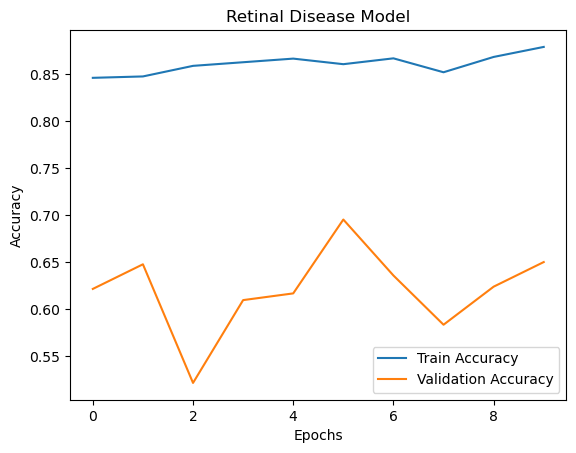

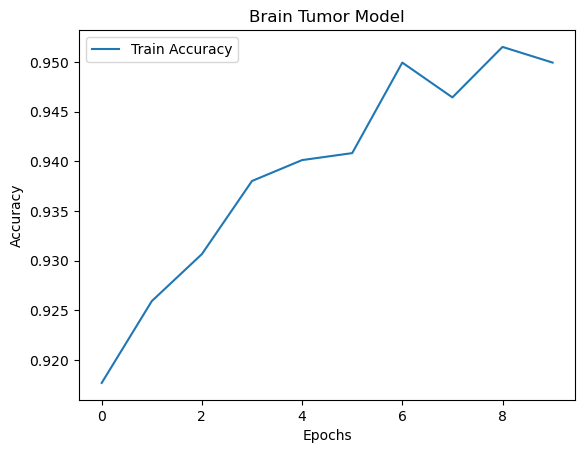

In [29]:
#Visualize Model Performance

#Plot Training History

import matplotlib.pyplot as plt

def plot_training_history(history, title="Training History"):
    plt.plot(history.history['accuracy'], label='Train Accuracy')
    if 'val_accuracy' in history.history:
        plt.plot(history.history['val_accuracy'], label='Validation Accuracy')
    plt.xlabel('Epochs')
    plt.ylabel('Accuracy')
    plt.title(title)
    plt.legend()
    plt.show()

plot_training_history(retinal_history, "Retinal Disease Model")
plot_training_history(brain_history, "Brain Tumor Model")

In [31]:
#Save Your Models for Presentation

retinal_model.save("retinal_model.h5")
brain_model.save("brain_model.h5")

In [33]:
import cv2
import numpy as np
from tensorflow.keras.models import load_model

def preprocess_image(image_path, target_size=(224, 224)):
    img = cv2.imread(image_path)
    if img is None:
        raise ValueError(f"Error: Unable to load image at {image_path}. Check the file path.")
    
    img = cv2.resize(img, target_size)
    img = img / 255.0  # Normalize
    img = np.expand_dims(img, axis=0)  # Add batch dimension
    return img

def predict_cancer_risk(retinal_model, brain_model, retinal_img, brain_img):
    # Get predictions
    retinal_pred = retinal_model.predict(retinal_img)
    brain_pred = brain_model.predict(brain_img)

    # Get predicted classes
    retinal_class = np.argmax(retinal_pred)
    brain_class = np.argmax(brain_pred)

    # Define cancer risk based on conditions
    if retinal_class in [1, 2, 3] and brain_class != 0:  # If disease in eye and brain tumor
        risk = "High Cancer Risk"
    elif retinal_class in [1, 2, 3] and brain_class == 0:
        risk = "Moderate Cancer Risk"
    elif retinal_class == 0 and brain_class != 0:
        risk = "Cancer Risk (Monitor Closely)"
    else:
        risk = "Low Cancer Risk"

    return risk, retinal_class, brain_class

# Load trained models
retinal_model = load_model("retinal_model.h5")
brain_model = load_model("brain_model.h5")

# Image paths
retinal_image_path = "/Users/blessygrace/Desktop/Capstone 2/seg_dataset/cataract/_0_4015166.jpg"
brain_image_path = "/Users/blessygrace/Desktop/Capstone 2/brainmri/Testing/meningioma/Te-me_0010.jpg"

# Preprocess images before passing them
retinal_img = preprocess_image(retinal_image_path)
brain_img = preprocess_image(brain_image_path)

# Get prediction
risk, retinal_disease, brain_tumor = predict_cancer_risk(retinal_model, brain_model, retinal_img, brain_img)

# Print results
print(f"Predicted Retinal Disease Class: {retinal_disease}")
print(f"Predicted Brain Tumor Class: {brain_tumor}")
print(f"Estimated Cancer Risk: {risk}")


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 300ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 298ms/step
Predicted Retinal Disease Class: 1
Predicted Brain Tumor Class: 2
Estimated Cancer Risk: High Cancer Risk


In [ ]:
def build_retinal_model(input_shape=(224, 224, 3), num_classes=4):
    base_model = MobileNetV2(input_shape=(224, 224, 3), include_top=False, weights='imagenet')
    x = GlobalAveragePooling2D()(base_model.output)
    x = Dense(512, activation='relu', kernel_regularizer=l2(0.01))(x)  # L2 Regularization
    x = Dropout(0.4)(x)  # Increased Dropout
    x = Dense(256, activation='relu', kernel_regularizer=l2(0.01))(x)
    x = Dropout(0.3)(x)
    outputs = Dense(num_classes, activation='softmax')(x)
    model = Model(inputs=base_model.input, outputs=outputs)
    for layer in base_model.layers[:-20]:  # Freeze all but last 20 layers
        layer.trainable = False
    model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])
    return model

retinal_model = build_retinal_model()

In [ ]:
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Dense, Dropout, GlobalAveragePooling2D, BatchNormalization
from tensorflow.keras.applications import EfficientNetB3
from tensorflow.keras.regularizers import l2
from tensorflow.keras.optimizers import Adam
import tensorflow as tf

def build_retinal_model(input_shape=(224, 224, 3), num_classes=4):
    # Use EfficientNetB3 for better feature extraction
    base_model = EfficientNetB3(input_shape=input_shape, include_top=False, weights='imagenet')

    # Unfreeze the last 50 layers instead of just 20 for better fine-tuning
    for layer in base_model.layers[:-75]:  
        layer.trainable = False

    x = GlobalAveragePooling2D()(base_model.output)

    # Fully connected layers with Batch Normalization and L2 Regularization
    x = Dense(512, activation='relu', kernel_regularizer=l2(0.01))(x)
    x = BatchNormalization()(x)  # Helps stabilize training
    x = Dropout(0.3)(x)  # Increased dropout for regularization

    x = Dense(256, activation='relu', kernel_regularizer=l2(0.01))(x)
    x = BatchNormalization()(x)
    x = Dropout(0.2)(x)

    outputs = Dense(num_classes, activation='softmax')(x)

    model = Model(inputs=base_model.input, outputs=outputs)

    # Use Adam optimizer with a learning rate scheduler
    initial_learning_rate = 1e-5
    lr_schedule = tf.keras.optimizers.schedules.ExponentialDecay(
        initial_learning_rate, decay_steps=1000, decay_rate=0.9, staircase=True
    )
    optimizer = tf.keras.optimizers.SGD(learning_rate=1e-3, momentum=0.9)

    model.compile(optimizer=optimizer, loss='categorical_crossentropy', metrics=['accuracy'])

    return model
